In [1]:
import imp
import os
import subprocess
import h5py
import numpy as np
from astropy.time import Time
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import HourLocator as HourLocator
from matplotlib.dates import MinuteLocator as MinuteLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy import units as u
from astropy.time import TimeDelta
from scipy import interpolate
from operator import itemgetter
from itertools import groupby
from astropy.convolution import convolve, Box1DKernel
import gc
import scipy.signal as signal

###########################################################
dir_in  = '/media/ordoga/15m_band1_survey/NCP/'
dir_out = '/media/ordoga/15m_band1_survey/NCP/'
###########################################################

In [138]:
day = 'Sep26_p2'

In [139]:
file = h5py.File('/media/ordoga/15m_band1_survey/NCP/'+day+'_NCP.h5','r')
freq = file['data']['beam_0']['band_SB0']['frequency'][:]/1e6
    
dataset = file['data']['beam_0']['band_SB0']['scan_0']

el = dataset['metadata']['elevation']
az = dataset['metadata']['azimuth']
t = dataset['metadata']['utc']
noise =dataset['metadata']['noise_state']
    
RR = dataset['data'][:,0,:]
LL = dataset['data'][:,1,:]
reRL = dataset['data'][:,2,:]
imRL = dataset['data'][:,3,:]


In [140]:
t_plt = Time(t, format='isot',scale='utc').mjd

print(t_plt.shape)
print(freq.shape)
print(LL.shape)


(36000,)
(679,)
(36000, 679)


In [141]:
def month_to_num(month_name):
    if month_name == 'Jan': month_num = '01'
    if month_name == 'Feb': month_num = '02'
    if month_name == 'Mar': month_num = '03'
    if month_name == 'Apr': month_num = '04'
    if month_name == 'May': month_num = '05'
    if month_name == 'Jun': month_num = '06'
    if month_name == 'Jul': month_num = '07'
    if month_name == 'Aug': month_num = '08'
    if month_name == 'Sep': month_num = '09'
    if month_name == 'Oct': month_num = '10'
    if month_name == 'Nov': month_num = '11'
    if month_name == 'Dec': month_num = '12'
    return(month_num)

i = 0
t_weath = []
temp_C = []


with open('../DVA2/DATA/weather/weather_survey_phase2.txt') as fp:
#with open('../DVA2/DATA/weather/weather_'+day+'_NCP.txt') as fp:
    for line in fp:
        t_weath.append(str( line.split()[2]+'-'+month_to_num(line.split()[1])+'-'+line.split()[0]+
                  'T'+line.split()[3]))
        temp_C.append(line.split()[4])

temp_C = np.array(temp_C,dtype=float)
t_weath_fix = Time(t_weath, format='isot',scale='utc')
t_weath_plt = t_weath_fix.mjd

In [142]:
%%time
################################################
# The number of integrations to include on either 
# side of each noise source instance:
n_off = 5
################################################

# Make arrays for noise source deflection:
LL_dnoise = []
RR_dnoise = []
reRL_dnoise = []
imRL_dnoise = []
t_noise = []

wnoise = np.where(noise == 1)[0]
#print(wnoise)
for k,g in groupby(enumerate(wnoise),lambda x:x[0]-x[1]):

    try:

        group = np.array(list(map(itemgetter(1),g)))
        #print(group)
        #print(group[1:-1])
        #middle = [group[int(np.floor((len(group)-1)/2))] ,group[int(np.ceil((len(group)-1)/2))]]
        #print(middle)
        offleft = [group[0]-n_off,group[0]-2]
        offright = [group[-1]+2,group[-1]+n_off]
        #print(offleft)
        #print(offright)
    
        LL_noise = np.nanmedian(LL[group[1:-1],:],axis=0)
        LL_off = (np.nanmedian(LL[offleft[0]:offleft[-1],:],axis=0) + np.nanmedian(LL[offright[0]:offright[-1],:],axis=0))/2.

        RR_noise = np.nanmedian(RR[group[1:-1],:],axis=0)
        RR_off = (np.nanmedian(RR[offleft[0]:offleft[-1],:],axis=0) + np.nanmedian(RR[offright[0]:offright[-1],:],axis=0))/2.
    
        reRL_noise = np.nanmedian(reRL[group[1:-1],:],axis=0)
        reRL_off = (np.nanmedian(reRL[offleft[0]:offleft[-1],:],axis=0) + np.nanmedian(reRL[offright[0]:offright[-1],:],axis=0))/2.
    
        imRL_noise = np.nanmedian(imRL[group[1:-1],:],axis=0)
        imRL_off = (np.nanmedian(imRL[offleft[0]:offleft[-1],:],axis=0) + np.nanmedian(imRL[offright[0]:offright[-1],:],axis=0))/2.

        t_noise.append(np.nanmedian(t_plt[group[1:-1]]))
        
        LL_dnoise.append(LL_noise - LL_off)
        RR_dnoise.append(RR_noise - RR_off)
        reRL_dnoise.append(reRL_noise - reRL_off)
        imRL_dnoise.append(imRL_noise - imRL_off)
        
    except:
        pass

LL_dnoise_arr = np.empty([len(LL_dnoise),len(LL_dnoise[0])])
RR_dnoise_arr = np.empty([len(RR_dnoise),len(RR_dnoise[0])])
reRL_dnoise_arr = np.empty([len(reRL_dnoise),len(reRL_dnoise[0])])
imRL_dnoise_arr = np.empty([len(imRL_dnoise),len(imRL_dnoise[0])])

for i in range(0,len(LL_dnoise)):
    LL_dnoise_arr[i,:] = LL_dnoise[i]
    RR_dnoise_arr[i,:] = RR_dnoise[i]
    reRL_dnoise_arr[i,:] = reRL_dnoise[i]
    imRL_dnoise_arr[i,:] = imRL_dnoise[i]

/home/ordoga/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


CPU times: user 605 ms, sys: 0 ns, total: 605 ms
Wall time: 605 ms


431.0


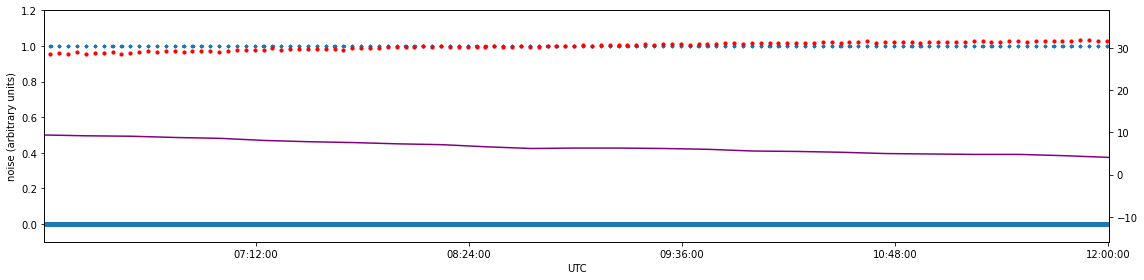

In [143]:
fig1, axs = plt.subplots(1,1,figsize=(16,4))

ii = 80
print(freq[ii])

axs.scatter(t_plt,noise,s=5)
axs2 = axs.twinx()
axs2.plot(t_weath_plt,temp_C,color='purple')
axs.scatter(t_noise,LL_dnoise_arr[:,ii]/np.nanmean(LL_dnoise_arr[:,ii]),s=10,c='red')

axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
axs.fmt_xdata = mdates.DateFormatter('%H:%M:%S')
axs.set_ylim(-0.1,1.2)
axs.set_xlim(t_plt[0],t_plt[-1])
axs.set_ylabel('noise (arbitrary units)')
axs.set_xlabel('UTC')
    
plt.tight_layout()
plt.savefig(dir_out+'noise_firing_NCP'+day+'.png')

/tmp/ipykernel_1061108/2107007174.py:5: RuntimeWarning: invalid value encountered in log10
  axs[0].scatter(freq,10*np.log10(LL_dnoise_arr[t_noise_idx,:]),s=5,label='LL')
/tmp/ipykernel_1061108/2107007174.py:6: RuntimeWarning: invalid value encountered in log10
  axs[0].scatter(freq,10*np.log10(RR_dnoise_arr[t_noise_idx,:]),s=5,label='RR')


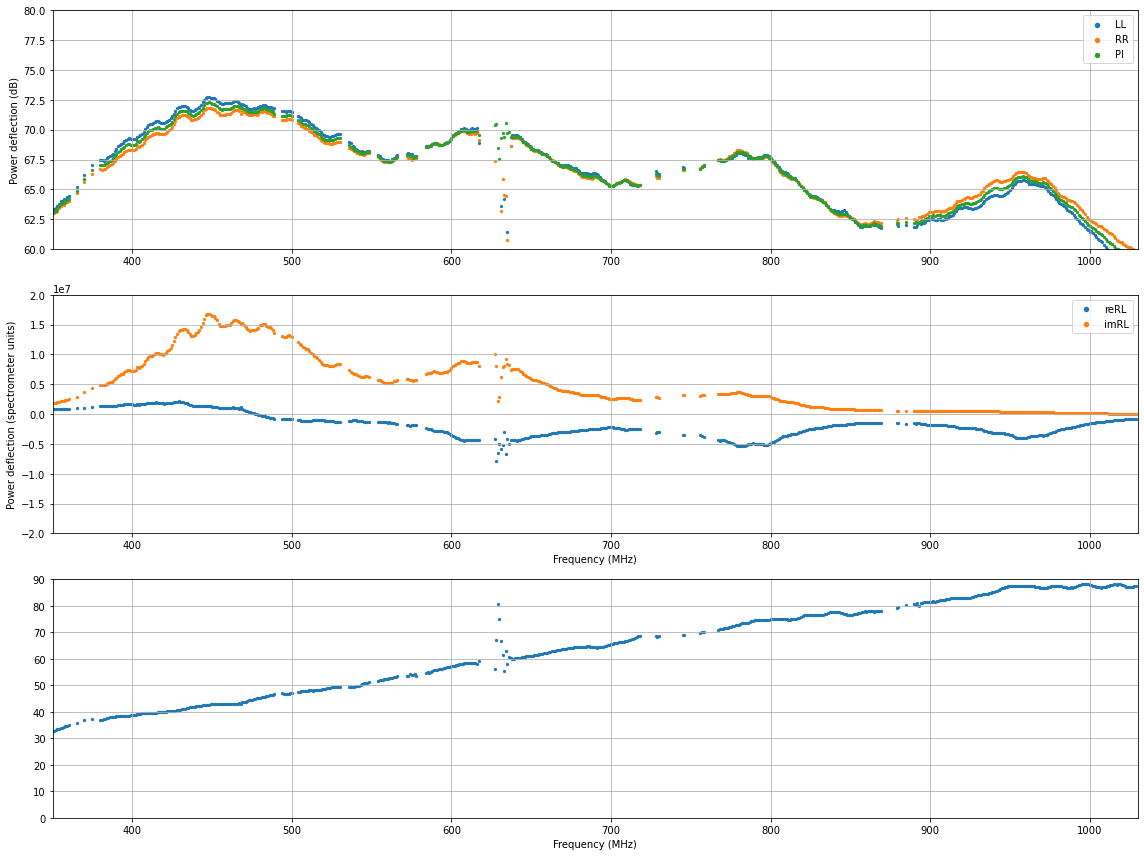

In [144]:
fig1, axs = plt.subplots(3,1,figsize=(16,12))

t_noise_idx = 20

axs[0].scatter(freq,10*np.log10(LL_dnoise_arr[t_noise_idx,:]),s=5,label='LL')
axs[0].scatter(freq,10*np.log10(RR_dnoise_arr[t_noise_idx,:]),s=5,label='RR')
axs[0].scatter(freq,10*np.log10(np.sqrt((reRL_dnoise_arr[t_noise_idx,:])**2 + 
                                        (imRL_dnoise_arr[t_noise_idx,:])**2)),s=5,label='PI')
axs[0].grid()
axs[0].set_ylim(60,80)
axs[0].set_xlim(350,1030)
axs[0].set_ylabel('Power deflection (dB)')
axs[0].legend(markerscale=2)

axs[1].scatter(freq,reRL_dnoise_arr[t_noise_idx,:],s=5,label='reRL')
axs[1].scatter(freq,imRL_dnoise_arr[t_noise_idx,:],s=5,label='imRL')
axs[1].grid()
axs[1].set_ylim(-2e7,2e7)
axs[1].set_xlim(350,1030)
axs[1].set_xlabel('Frequency (MHz)')
axs[1].set_ylabel('Power deflection (spectrometer units)')
axs[1].legend(markerscale=2)

axs[2].scatter(freq,(180/np.pi)*0.5*np.arctan2(imRL_dnoise_arr[t_noise_idx,:],reRL_dnoise_arr[t_noise_idx,:]),s=5,label='angle')
axs[2].grid()
axs[2].set_ylim(0,90)
axs[2].set_xlim(350,1030)
axs[2].set_xlabel('Frequency (MHz)')
#axs[1].set_ylabel('Power deflection (spectrometer units)')
#axs[1].legend(markerscale=2)

plt.tight_layout()
plt.savefig(dir_out+'noise_power_deflection_vs_freq_NCP'+day+'.png')

In [145]:
%%time
LL_dnoise_fix = LL_dnoise_arr.copy()
RR_dnoise_fix = RR_dnoise_arr.copy()
reRL_dnoise_fix = reRL_dnoise_arr.copy()
imRL_dnoise_fix = imRL_dnoise_arr.copy()
std_mult = 1.0
for i in range(0,len(freq)):
    
    print(i,freq[i])    
    for j in range(0,len(t_noise)):
        
        window = 10
        if ((j >= window) & (j < len(t_noise)-window)):
            LL_near = np.nanmedian(LL_dnoise_arr[j-window:j+window,i])
            RR_near = np.nanmedian(RR_dnoise_arr[j-window:j+window,i])
        else:
            if j < window:
                LL_near = np.nanmedian(LL_dnoise_arr[0:j+window,i])
                RR_near = np.nanmedian(RR_dnoise_arr[0:j+window,i])
            if j >= len(t_noise)-window:
                LL_near = np.nanmedian(LL_dnoise_arr[j-window:-1,i])
                RR_near = np.nanmedian(RR_dnoise_arr[j-window:-1,i])
        
        if ( LL_dnoise_arr[j,i] > 1.1*LL_near):
            LL_dnoise_fix[j,i] = np.nan
            reRL_dnoise_fix[j,i] = np.nan
            imRL_dnoise_fix[j,i] = np.nan
        if ( LL_dnoise_arr[j,i] < 0.9*LL_near):
            LL_dnoise_fix[j,i] = np.nan
            reRL_dnoise_fix[j,i] = np.nan
            imRL_dnoise_fix[j,i] = np.nan
            
        if ( RR_dnoise_arr[j,i] > 1.1*RR_near):
            RR_dnoise_fix[j,i] = np.nan
            reRL_dnoise_fix[j,i] = np.nan
            imRL_dnoise_fix[j,i] = np.nan
        if ( RR_dnoise_arr[j,i] < 0.9*RR_near):
            RR_dnoise_fix[j,i] = np.nan
            reRL_dnoise_fix[j,i] = np.nan
            imRL_dnoise_fix[j,i] = np.nan


0 351.0
1 352.0
2 353.0
3 354.0
4 355.0
5 356.0
6 357.0
7 358.0
8 359.0
9 360.0
10 361.0
11 362.0
12 363.0
13 364.0
14 365.0
15 366.0
16 367.0
17 368.0
18 369.0
19 370.0
20 371.0
21 372.0
22 373.0
23 374.0
24 375.0
25 376.0
26 377.0
27 378.0
28 379.0
29 380.0
30 381.0
31 382.0
32 383.0
33 384.0
34 385.0
35 386.0
36 387.0
37 388.0
38 389.0


/home/ordoga/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


39 390.0
40 391.0
41 392.0
42 393.0
43 394.0
44 395.0
45 396.0
46 397.0
47 398.0
48 399.0
49 400.0
50 401.0
51 402.0
52 403.0
53 404.0
54 405.0
55 406.0
56 407.0
57 408.0
58 409.0
59 410.0
60 411.0
61 412.0
62 413.0
63 414.0
64 415.0
65 416.0
66 417.0
67 418.0
68 419.0
69 420.0
70 421.0
71 422.0
72 423.0
73 424.0
74 425.0
75 426.0
76 427.0
77 428.0
78 429.0
79 430.0
80 431.0
81 432.0
82 433.0
83 434.0
84 435.0
85 436.0
86 437.0
87 438.0
88 439.0
89 440.0
90 441.0
91 442.0
92 443.0
93 444.0
94 445.0
95 446.0
96 447.0
97 448.0
98 449.0
99 450.0
100 451.0
101 452.0
102 453.0
103 454.0
104 455.0
105 456.0
106 457.0
107 458.0
108 459.0
109 460.0
110 461.0
111 462.0
112 463.0
113 464.0
114 465.0
115 466.0
116 467.0
117 468.0
118 469.0
119 470.0
120 471.0
121 472.0
122 473.0
123 474.0
124 475.0
125 476.0
126 477.0
127 478.0
128 479.0
129 480.0
130 481.0
131 482.0
132 483.0
133 484.0
134 485.0
135 486.0
136 487.0
137 488.0
138 489.0
139 490.0
140 491.0
141 492.0
142 493.0
143 494.0
144 495.0
1

In [146]:
%%time

t_mean = np.nanmean(t_plt)
print(t_mean)

LL_fit = np.empty_like(LL)
RR_fit = np.empty_like(RR)
reRL_fit = np.empty_like(reRL)
imRL_fit = np.empty_like(imRL)
print(LL_fit.shape)
print(LL.shape)

LL_fit_noise_pt = np.empty_like(LL_dnoise_arr)
RR_fit_noise_pt = np.empty_like(RR_dnoise_arr)
reRL_fit_noise_pt = np.empty_like(reRL_dnoise_arr)
imRL_fit_noise_pt = np.empty_like(imRL_dnoise_arr)

for i in range(0,len(freq)):
    print(freq[i])
    try:
        wuse = np.where(np.isfinite(LL_dnoise_fix[:,i]))[0]
        pL = np.polyfit(np.array(t_noise)[wuse]-t_mean,LL_dnoise_fix[wuse,i],9)
        LL_fit[:,i] = np.polyval(pL, t_plt-t_mean)
        LL_fit_noise_pt[:,i] = np.polyval(pL, t_noise-t_mean)

        wuse = np.where(np.isfinite(RR_dnoise_fix[:,i]))[0]
        pR = np.polyfit(np.array(t_noise)[wuse]-t_mean,RR_dnoise_fix[wuse,i],9)
        RR_fit[:,i] = np.polyval(pR, t_plt-t_mean)
        RR_fit_noise_pt[:,i] = np.polyval(pR, t_noise-t_mean)
    
        wuse = np.where(np.isfinite(reRL_dnoise_fix[:,i]))[0]
        pre = np.polyfit(np.array(t_noise)[wuse]-t_mean,reRL_dnoise_fix[wuse,i],9)
        reRL_fit[:,i] = np.polyval(pre, t_plt-t_mean)
        reRL_fit_noise_pt[:,i] = np.polyval(pre, t_noise-t_mean)
    
        wuse = np.where(np.isfinite(imRL_dnoise_fix[:,i]))[0]
        pim = np.polyfit(np.array(t_noise)[wuse]-t_mean,imRL_dnoise_fix[wuse,i],9)
        imRL_fit[:,i] = np.polyval(pim, t_plt-t_mean)
        imRL_fit_noise_pt[:,i] = np.polyval(pim, t_noise-t_mean)
    except:
        
        pass
    
print(LL_fit.shape)

59848.3753206019
(36000, 679)
(36000, 679)
351.0
352.0
353.0
354.0
355.0
356.0
357.0
358.0
359.0
360.0
361.0
362.0
363.0
364.0
365.0
366.0
367.0
368.0
369.0
370.0
371.0
372.0
373.0
374.0
375.0
376.0
377.0
378.0
379.0
380.0
381.0
382.0
383.0
384.0
385.0
386.0
387.0
388.0
389.0
390.0
391.0
392.0
393.0
394.0
395.0
396.0
397.0
398.0
399.0
400.0
401.0
402.0
403.0
404.0
405.0
406.0
407.0
408.0
409.0
410.0
411.0
412.0
413.0
414.0
415.0
416.0
417.0
418.0
419.0
420.0
421.0
422.0
423.0
424.0
425.0
426.0
427.0
428.0
429.0
430.0
431.0
432.0
433.0
434.0
435.0
436.0
437.0
438.0
439.0
440.0
441.0
442.0
443.0
444.0
445.0
446.0
447.0
448.0
449.0
450.0
451.0
452.0
453.0
454.0
455.0
456.0
457.0
458.0
459.0
460.0
461.0
462.0
463.0
464.0
465.0
466.0
467.0
468.0
469.0
470.0
471.0
472.0
473.0
474.0
475.0
476.0
477.0
478.0
479.0
480.0
481.0
482.0
483.0
484.0
485.0
486.0
487.0
488.0
489.0
490.0
491.0
492.0
493.0
494.0
495.0
496.0
497.0
498.0
499.0
500.0
501.0
502.0
503.0
504.0
505.0
506.0
507.0
508.0
509.0
510

800.0


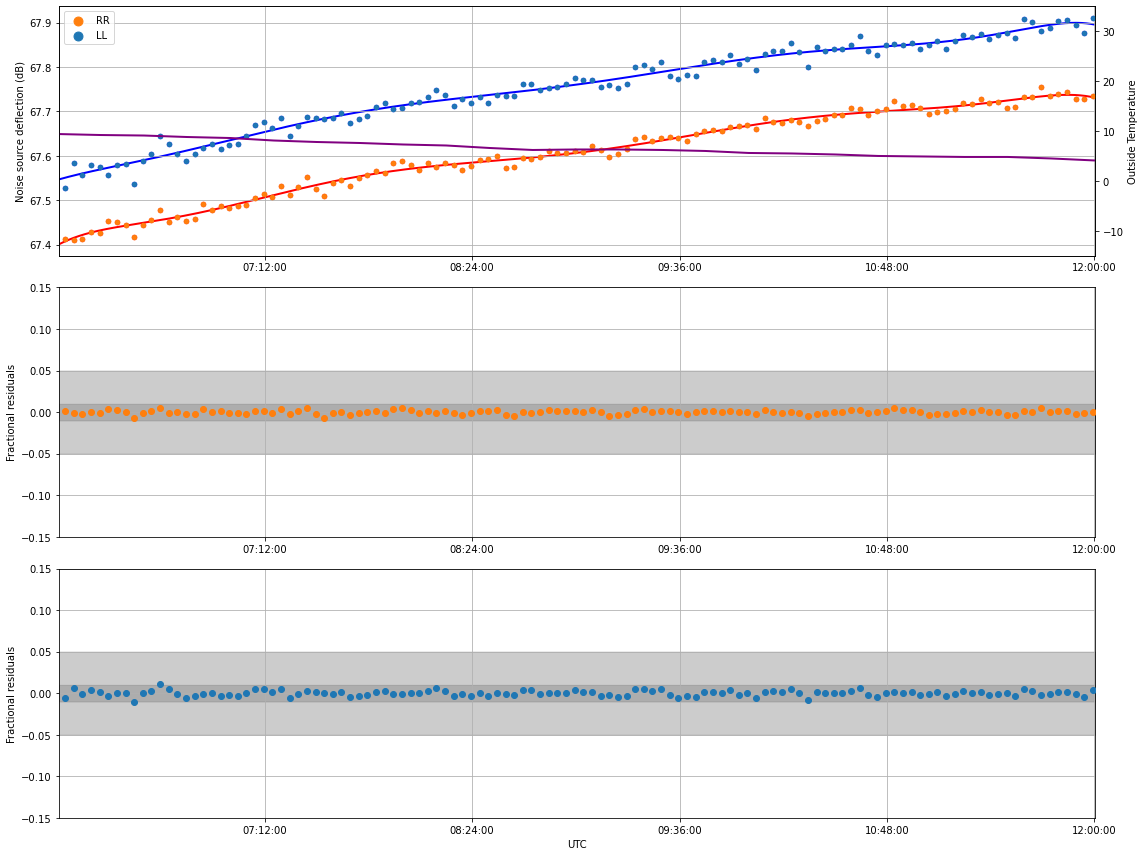

In [147]:
fplot = 800
df = freq[1]-freq[0]
wf = np.where(abs(freq-fplot)<=df/2)[0][0]
print(freq[wf])

fig1, axs = plt.subplots(3,1,figsize=(16,12))

axs[0].scatter(t_noise,10*np.log10(RR_dnoise_arr[:,wf]),s=20,color='red')
axs[0].scatter(t_noise,10*np.log10(RR_dnoise_fix[:,wf]),s=20,color='C1',label='RR',zorder=10)
axs[0].scatter(t_noise,10*np.log10(LL_dnoise_arr[:,wf]),s=20,color='blue')
axs[0].scatter(t_noise,10*np.log10(LL_dnoise_fix[:,wf]),s=20,color='C0',label='LL',zorder=10)

axs[0].plot(t_plt,10*np.log10(LL_fit[:,wf]),color='blue',linewidth=2,zorder=0)
axs[0].plot(t_plt,10*np.log10(RR_fit[:,wf]),color='red',linewidth=2,zorder=0)
#axs[0].set_ylim(68,72)
axs[0].set_ylabel('Noise source deflection (dB)')
axs[0].legend(markerscale=2)

ax2 = axs[0].twinx()
ax2.plot(t_weath_plt,temp_C,color='purple',linewidth=2)
ax2.set_ylim(-15,35)
ax2.set_ylabel('Outside Temperature')

axs[1].scatter(t_noise,(RR_dnoise_fix[:,wf]-RR_fit_noise_pt[:,wf])/RR_dnoise_fix[:,wf],
               color='C1',zorder=10)
axs[1].set_ylim(-0.15,0.15)
axs[1].fill_between(t_plt,-0.05,0.05,zorder=0,color='grey',alpha=0.4)
axs[1].fill_between(t_plt,-0.01,0.01,zorder=1,color='grey',alpha=0.4)
axs[1].set_ylabel('Fractional residuals')

axs[2].scatter(t_noise,(LL_dnoise_fix[:,wf]-LL_fit_noise_pt[:,wf])/LL_dnoise_fix[:,wf],
               color='C0',zorder=10)
axs[2].set_ylim(-0.15,0.15)
axs[2].fill_between(t_plt,-0.05,0.05,zorder=0,color='grey',alpha=0.4)
axs[2].fill_between(t_plt,-0.01,0.01,zorder=1,color='grey',alpha=0.4)
axs[2].set_ylabel('Fractional residuals')


for i in range(0,3):
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    axs[i].fmt_xdata = mdates.DateFormatter('%H:%M:%S')
    axs[i].set_xlim(t_plt[0],t_plt[-1])
    axs[i].grid()
axs[2].set_xlabel('UTC')
    
plt.tight_layout()
plt.savefig(dir_out+'noise_deflection_fits_800MHz_NCP'+day+'.png')


800.0


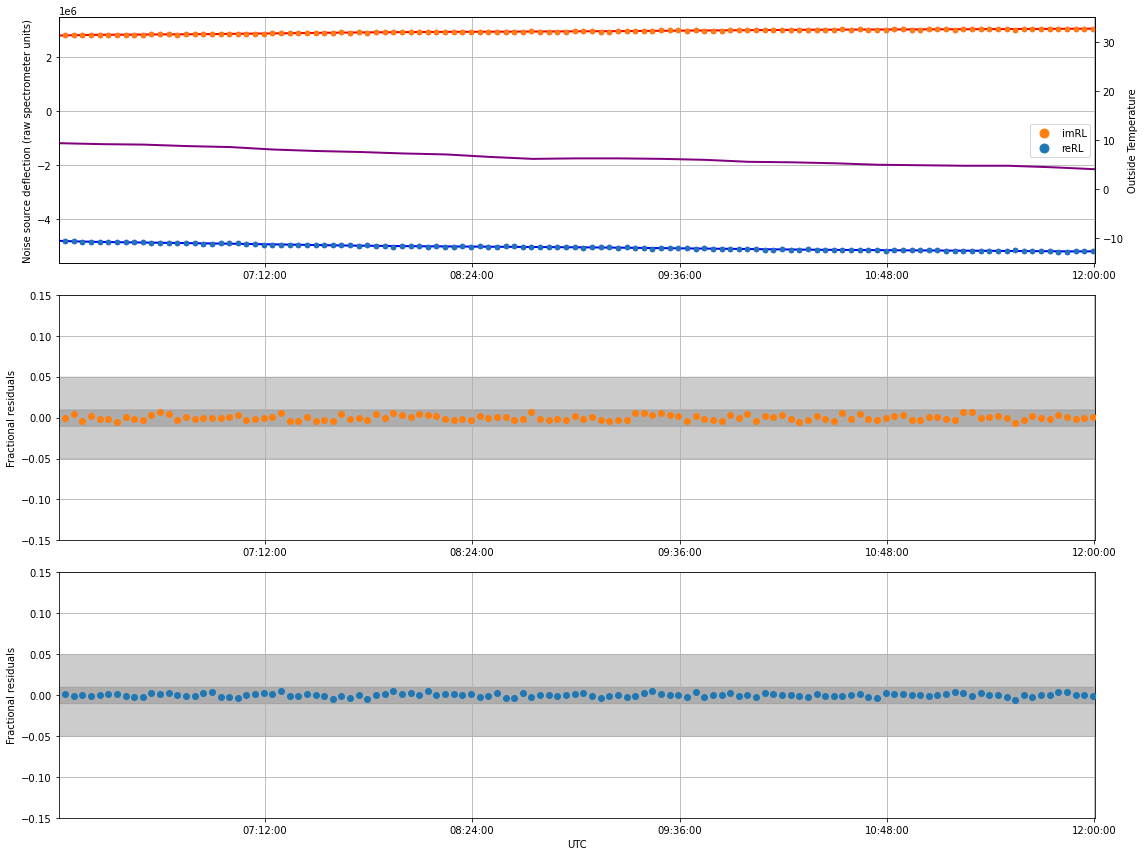

In [148]:
fplot = 800
df = freq[1]-freq[0]
wf = np.where(abs(freq-fplot)<=df/2)[0][0]
print(freq[wf])

fig1, axs = plt.subplots(3,1,figsize=(16,12))

axs[0].scatter(t_noise,imRL_dnoise_arr[:,wf],s=20,color='red')
axs[0].scatter(t_noise,imRL_dnoise_fix[:,wf],s=20,color='C1',label='imRL',zorder=10)
axs[0].scatter(t_noise,reRL_dnoise_arr[:,wf],s=20,color='blue')
axs[0].scatter(t_noise,reRL_dnoise_fix[:,wf],s=20,color='C0',label='reRL',zorder=10)
axs[0].plot(t_plt,reRL_fit[:,wf],color='blue',linewidth=2,zorder=0)
axs[0].plot(t_plt,imRL_fit[:,wf],color='red',linewidth=2,zorder=0)
#axs[0].set_ylim(65,69)
axs[0].set_ylabel('Noise source deflection (raw spectrometer units)')
axs[0].legend(markerscale=2)

ax2 = axs[0].twinx()
ax2.plot(t_weath_plt,temp_C,color='purple',linewidth=2)
ax2.set_ylim(-15,35)
ax2.set_ylabel('Outside Temperature')

axs[1].scatter(t_noise,(imRL_dnoise_fix[:,wf]-imRL_fit_noise_pt[:,wf])/imRL_dnoise_fix[:,wf],
               color='C1',zorder=10)
axs[1].set_ylim(-0.15,0.15)
axs[1].fill_between(t_plt,-0.05,0.05,zorder=0,color='grey',alpha=0.4)
axs[1].fill_between(t_plt,-0.01,0.01,zorder=1,color='grey',alpha=0.4)
axs[1].set_ylabel('Fractional residuals')

axs[2].scatter(t_noise,(reRL_dnoise_fix[:,wf]-reRL_fit_noise_pt[:,wf])/reRL_dnoise_fix[:,wf],
               color='C0',zorder=10)
axs[2].set_ylim(-0.15,0.15)
axs[2].fill_between(t_plt,-0.05,0.05,zorder=0,color='grey',alpha=0.4)
axs[2].fill_between(t_plt,-0.01,0.01,zorder=1,color='grey',alpha=0.4)
axs[2].set_ylabel('Fractional residuals')


for i in range(0,3):
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    axs[i].fmt_xdata = mdates.DateFormatter('%H:%M:%S')
    axs[i].set_xlim(t_plt[0],t_plt[-1])
    axs[i].grid()
axs[2].set_xlabel('UTC')
    
plt.tight_layout()
plt.savefig(dir_out+'noise_deflection_pol_fits_800MHz_NCP'+day+'.png')


800.0


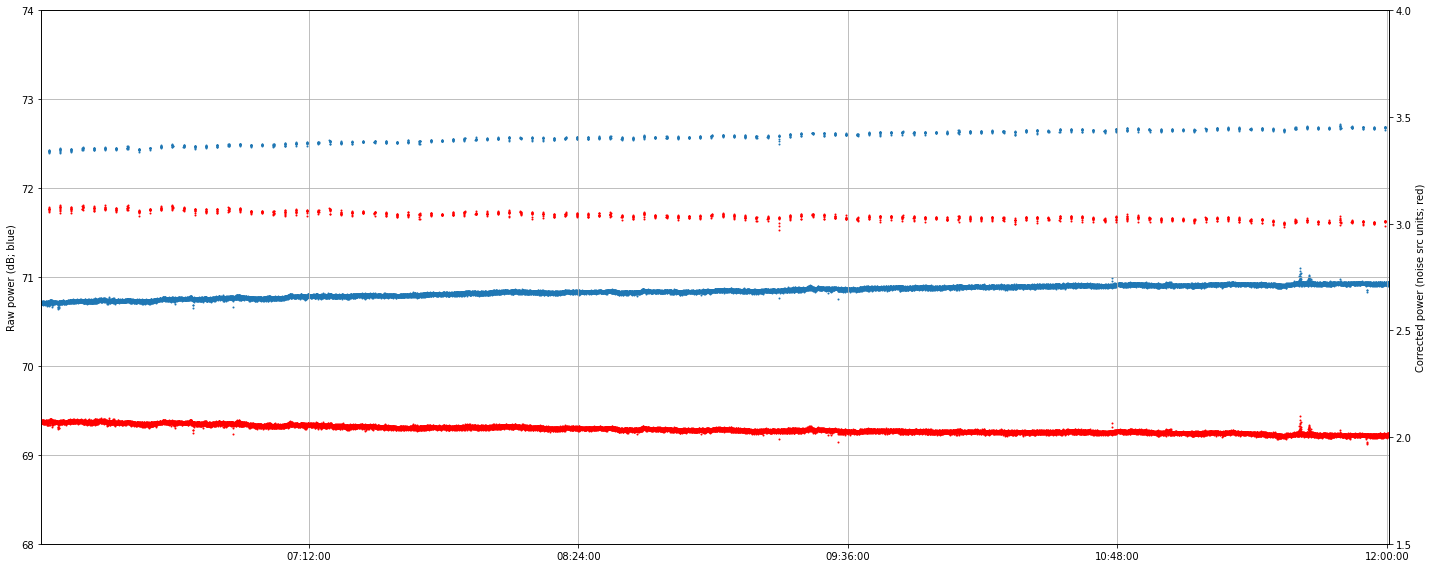

In [149]:
fplot = 800
df = freq[1]-freq[0]
wf = np.where(abs(freq-fplot)<=df/2)[0][0]
print(freq[wf])


lims_raw1 = [65,65,65]
lims_raw2 = [75,75,75]
lims_cor1 = [2,2,2]
lims_cor2 = [8,8,8]

sz=1
fig1, axs = plt.subplots(1,1,figsize=(20,8))

axs.scatter(t_plt,10*np.log10(LL[:,wf]),s=sz)
axs.set_ylim(68,74)
        
ax2 = axs.twinx()
ax2.scatter(t_plt,LL[:,wf]/LL_fit[:,wf],s=sz,color='red')
ax2.set_ylim(1.5,4)
ax2.set_ylabel('Corrected power (noise src units; red)')
    
axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
axs.fmt_xdata = mdates.DateFormatter('%H:%M:%S')
axs.grid()
axs.set_ylabel('Raw power (dB; blue)')

axs.set_xlim(t_plt[0],t_plt[-1])
#axs[0].set_xlim(raster1_start_mjd,raster1_start_mjd+0.005)
#axs[0].set_ylim(2e7,4e7)

plt.tight_layout()
plt.savefig(dir_out+'correction_example_LL_800MHz_NCP'+day+'.png')


b'2022-09-26T09:20:28.000004Z'


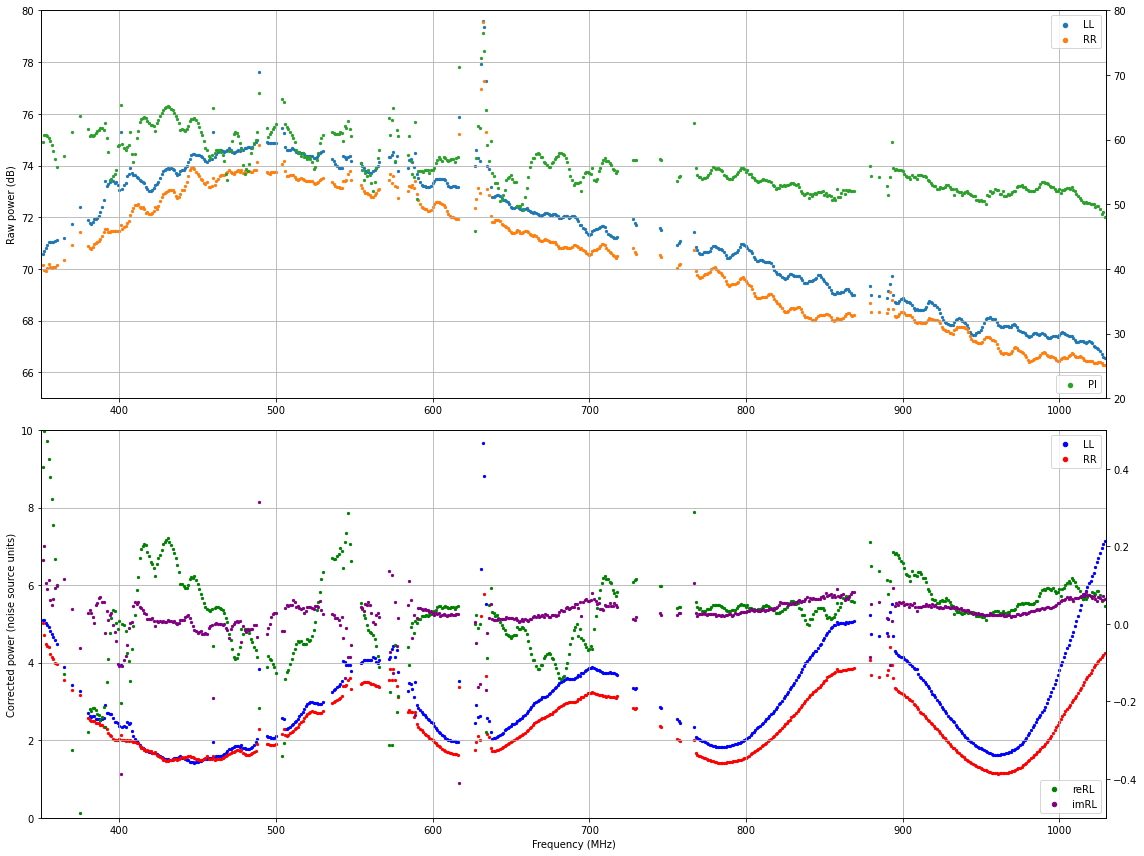

In [150]:
fig1, axs = plt.subplots(2,1,figsize=(16,12))

t_idx = 20000
print(t[t_idx])
s = 5

axs[0].scatter(freq,10*np.log10(LL[t_idx,:]),s=s,color='C0',label='LL')
axs[0].scatter(freq,10*np.log10(RR[t_idx,:]),s=s,color='C1',label='RR')
ax2 = axs[0].twinx()
ax2.scatter(freq,10*np.log10(np.sqrt((reRL[t_idx,:])**2+(imRL[t_idx])**2)),s=s,color='C2',label='PI')
axs[0].grid()
axs[0].set_ylim(65,80)
ax2.set_ylim(20,80)
axs[0].set_xlim(350,1030)
axs[0].set_ylabel('Raw power (dB)')
axs[0].legend(markerscale=2,loc='upper right')
ax2.legend(markerscale=2,loc='lower right')

axs[1].scatter(freq,LL[t_idx,:]/LL_fit[t_idx,:],s=s,color='blue',label='LL')
axs[1].scatter(freq,RR[t_idx,:]/RR_fit[t_idx,:],s=s,color='red',label='RR')
ax2 = axs[1].twinx()

PAcal = 0.5*np.arctan2(imRL_fit[t_idx,:],reRL_fit[t_idx,:])
PIcal = np.sqrt(imRL_fit[t_idx,:]**2 + reRL_fit[t_idx,:]**2)
reRL_corr = ( reRL[t_idx,:]*np.cos(2*PAcal) + imRL[t_idx,:]*np.sin(2*PAcal) )/PIcal
imRL_corr = ( imRL[t_idx,:]*np.cos(2*PAcal) - reRL[t_idx,:]*np.sin(2*PAcal) )/PIcal

#ax2.scatter(freq,np.sqrt(reRL_corr**2+imRL_corr**2),s=s,color='green',label='PI')
ax2.scatter(freq,reRL_corr,s=s,color='green',label='reRL')
ax2.scatter(freq,imRL_corr,s=s,color='purple',label='imRL')

ax2.set_ylim(-0.5,0.5)
axs[1].set_ylim(0,10)
axs[1].grid()
axs[1].set_xlim(350,1030)
axs[1].set_ylabel('Corrected power (noise source units)')
axs[1].set_xlabel('Frequency (MHz)')
axs[1].legend(markerscale=2,loc='upper right')
ax2.legend(markerscale=2,loc='lower right')

plt.tight_layout()
plt.savefig(dir_out+'correction_example_spectrum_NCP'+day+'.png')


800.0


<timed exec>:26: RuntimeWarning: divide by zero encountered in log10
<timed exec>:26: RuntimeWarning: invalid value encountered in log10


CPU times: user 7.99 s, sys: 1.49 s, total: 9.49 s
Wall time: 9.49 s


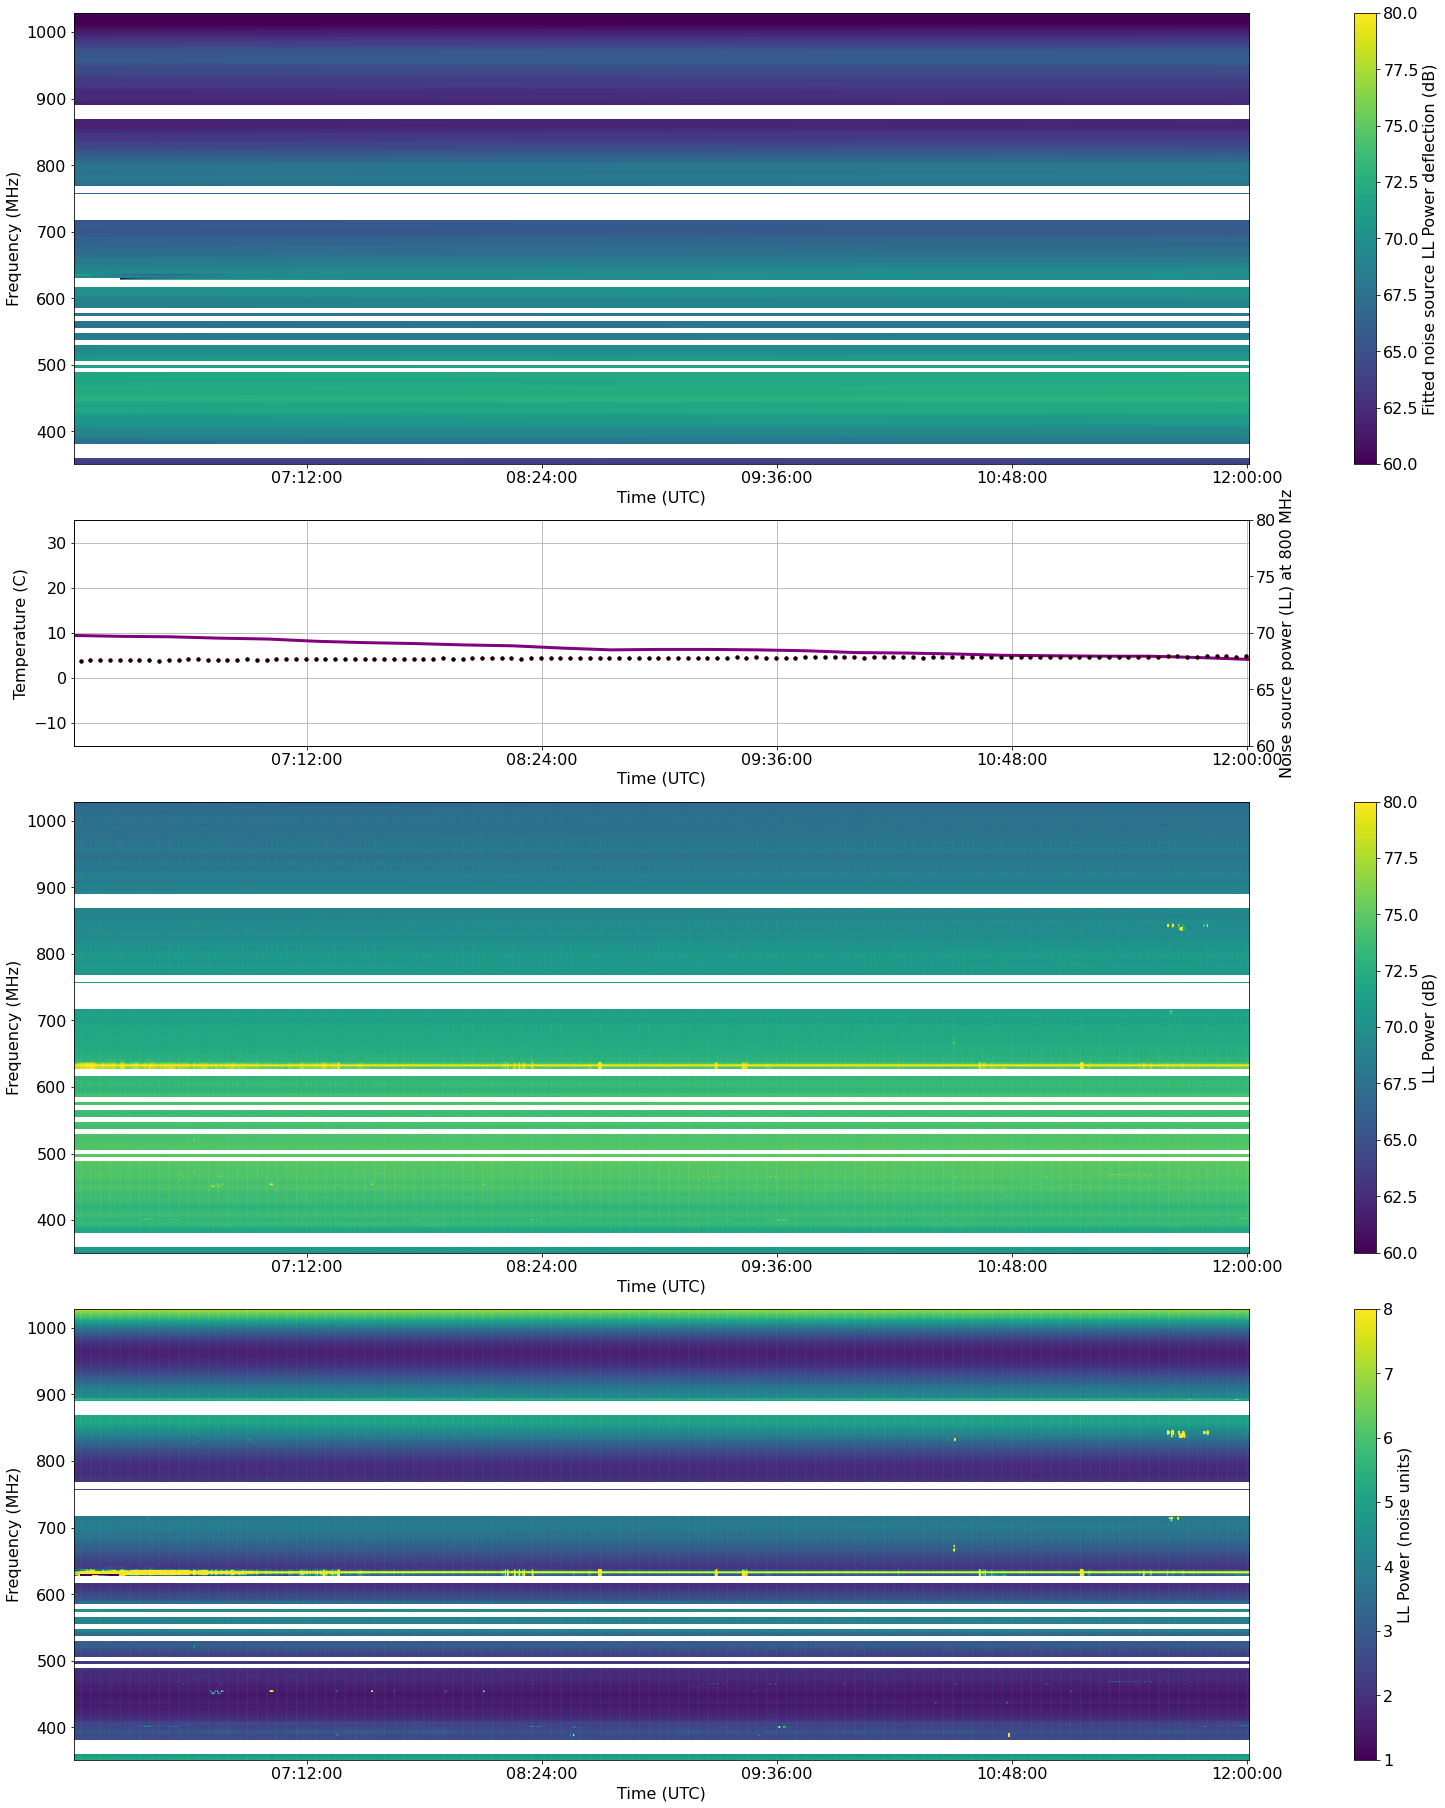

In [151]:
%%time

#Gmin = 0.9
#Gmax = 1.1
noisemin = 60
noisemax = 80
dBmin = 60
dBmax = 80

fplot = 800
df = freq[1]-freq[0]
wf = np.where(abs(freq-fplot)<=df/2)[0][0]
print(freq[wf])

fig1, axs = plt.subplots(4,1,figsize=(20,25),sharex=True,gridspec_kw={'height_ratios': [1,0.5,1,1]},
                         constrained_layout=True)
fs = 16

data1 = LL.T
data2 = LL_fit.T
#data1[RFI_mask_idx,:] = np.nan
#data2[RFI_mask_idx,:] = np.nan

extent = [t_plt[0],t_plt[-1],freq[0],freq[-1]]
    
im2 = axs[2].imshow(10*np.log10(data1),aspect='auto',vmin=dBmin,vmax=dBmax,origin='lower',
                    extent=extent,cmap='viridis')    
im0 = axs[0].imshow(10*np.log10(data2),aspect='auto',vmin=noisemin,vmax=noisemax,origin='lower',
                    extent=extent,cmap='viridis')
im3 = axs[3].imshow(data1/data2,aspect='auto',vmin=1,vmax=8,origin='lower',
                    extent=extent,cmap='viridis')


cbar0= fig1.colorbar(im0,ax=axs[0])
cbar0.ax.tick_params(labelsize=fs) 
cbar0.set_label('Fitted noise source LL Power deflection (dB)', fontsize=fs)

cbar2= fig1.colorbar(im2,ax=axs[2])
cbar2.ax.tick_params(labelsize=fs) 
cbar2.set_label('LL Power (dB)', fontsize=fs)

cbar3= fig1.colorbar(im3,ax=axs[3])
cbar3.ax.tick_params(labelsize=fs) 
cbar3.set_label('LL Power (noise units)', fontsize=fs)

axs[1].plot(t_weath_plt,temp_C,color='purple',linewidth=3)
axs[1].set_ylim(-15,35)     
axs[1].set_ylabel('Temperature (C)',fontsize=fs)
ax2 = axs[1].twinx()
ax2.scatter(t_noise,10*np.log10(LL_dnoise_arr[:,wf]),s=10,color='red')
ax2.scatter(t_noise,10*np.log10(LL_dnoise_fix[:,wf]),s=10,color='k')
ax2.set_ylim(noisemin,noisemax)
ax2.set_ylabel('Noise source power (LL) at 800 MHz',fontsize=fs)
ax2.tick_params(axis='y', labelsize=fs)
axs[1].grid() 



for i in range(0,4):
    axs[i].set_xlim(t_plt[0],t_plt[-1])
    axs[i].tick_params(axis='both', labelsize=fs,labelbottom=True)
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    axs[i].fmt_xdata = mdates.DateFormatter('%H:%M:%S')
    axs[i].set_xlabel('Time (UTC)',fontsize=fs)
    if i != 1:
        axs[i].set_ylim(freq[0],freq[-1])
        axs[i].set_ylabel('Frequency (MHz)',fontsize=fs)
    
#plt.tight_layout()
plt.savefig(dir_out+'waterfall_NCP'+day+'.png')


In [152]:
def write_gain_corrected(file,RR_out,LL_out,reRL_out,imRL_out,infiles,outfiles,inname,outname,GR,GL,GreRL,GimRL):

    cmd2 = 'cp '+infiles+inname+' '+outfiles+outname+'.h5'
    os.system(cmd2)
    file_new = h5py.File(outfiles+outname+'.h5','r+')
    
    print(inname)
    print(RR_out.shape)
    print(GR.shape)
    print(file_new['data']['beam_0']['band_SB0']['scan_0']['data'][:,0,:].shape)
    print('')
    
    file_new['data']['beam_0']['band_SB0']['scan_0']['data'][:,0,:] = RR_out/GR
    file_new['data']['beam_0']['band_SB0']['scan_0']['data'][:,1,:] = LL_out/GL
    
    
    PAcal = 0.5*np.arctan2(GimRL,GreRL)
    PIcal = np.sqrt(GimRL**2 + GreRL**2)
    
    print('')
    print((180./np.pi)*PAcal[:,300])
    print('')
    
    reRL_corr = ( reRL_out*np.cos(2*PAcal) + imRL_out*np.sin(2*PAcal) )/PIcal
    imRL_corr = ( imRL_out*np.cos(2*PAcal) - reRL_out*np.sin(2*PAcal) )/PIcal
        
    file_new['data']['beam_0']['band_SB0']['scan_0']['data'][:,2,:] = reRL_corr
    file_new['data']['beam_0']['band_SB0']['scan_0']['data'][:,3,:] = imRL_corr
           
    file_new.close()

inname  = day+'_NCP.h5'
outname = day+'_NCP_noise_corr'

file = h5py.File(dir_in+inname,'r')

print(freq[300])

write_gain_corrected(file,RR,LL,reRL,imRL,dir_in,dir_out,inname,outname,
                    RR_fit,LL_fit,reRL_fit,imRL_fit)



651.0
Sep26_p2_NCP.h5
(36000, 679)
(36000, 679)
(36000, 679)


[61.25023196 61.25013207 61.25003226 ... 61.1208124  61.12085679
 61.12090124]

